# RDS Homework 2 Template
## Spring 2024


In [1]:
!pip install shap

In [2]:
from __future__ import print_function

import shap
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.ensemble
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import fetch_20newsgroups
from collections import defaultdict
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Configs
np.random.seed(1)
shap.initjs()
sns.set_style("whitegrid")

plot_shap=True # NOTE: Turn False to disable shap plots as they can be slow to load

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Problem 3

### Part (A)

In [3]:
# Mark the categories of interest
categories = ['alt.atheism', 'soc.religion.christian']

# Fetch the data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

# Set outcome class names
class_names = ['atheism', 'christian']

# Initialize & fit tf-idf vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train = vectorizer.fit_transform(newsgroups_train.data)
X_test = vectorizer.transform(newsgroups_test.data)
y_train = newsgroups_train.target
y_test = newsgroups_test.target

# Train & fit the classifier
clf = SGDClassifier(loss='log_loss', random_state=42)
clf.fit(X_train, y_train)

SGDClassifier(loss='log_loss', random_state=42)

### Part (B)

In [20]:
import numpy as np
import shap
import sklearn.metrics
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(
    subset='train',
    categories=categories,
    remove=('headers', 'footers', 'quotes'),
    random_state=42
)
newsgroups_test = fetch_20newsgroups(
    subset='test',
    categories=categories,
    remove=('headers', 'footers', 'quotes'),
    random_state=42
)

X_train_text = newsgroups_train.data
y_train = newsgroups_train.target
X_test_text = newsgroups_test.data
y_test = newsgroups_test.target
class_names = newsgroups_train.target_names

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

clf = SGDClassifier(loss='log_loss', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

#confusion matrix
conf_mat = sklearn.metrics.confusion_matrix(y_test, y_pred)

print("Class names:", class_names)
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix (rows = true, cols = predicted):")
print(conf_mat)

explainer = shap.LinearExplainer(clf, X_train)

correct_indices = np.where(y_pred == y_test)[0]
incorrect_indices = np.where(y_pred != y_test)[0]
docs_to_explain = []
for i in correct_indices[:2]:
    docs_to_explain.append(i)
for i in incorrect_indices[:2]:
    docs_to_explain.append(i)
if len(docs_to_explain) < 5 and len(correct_indices) + len(incorrect_indices) > len(docs_to_explain):
    extra_idx = None
    if len(correct_indices) > 2:
        extra_idx = correct_indices[2]
    elif len(incorrect_indices) > 2:
        extra_idx = incorrect_indices[2]
    if extra_idx is not None:
        docs_to_explain.append(extra_idx)
docs_to_explain = docs_to_explain[:5]

print("\nDocuments selected for SHAP explanations:", docs_to_explain)

for doc_idx in docs_to_explain:
    predicted_class = y_pred[doc_idx]
    true_class = y_test[doc_idx]
    print("\n------------------------------------------------")
    print(f"Document index: {doc_idx}")
    print(f"True label: {class_names[true_class]}")
    print(f"Predicted label: {class_names[predicted_class]}")
    doc_text = X_test_text[doc_idx]
    print("Text snippet:", doc_text[:300].replace('\n', ' '), "...")

    shap_values_all = explainer.shap_values(X_test[[doc_idx]])
    shap_values = shap_values_all[0]

    doc_words = X_test[doc_idx].nonzero()[1]
    feature_names = vectorizer.get_feature_names_out()
    word_influences = []
    for w in doc_words:
        word_influences.append((feature_names[w], shap_values[w]))
    word_influences.sort(key=lambda x: abs(x[1]), reverse=True)
    print("\nTop 10 words by absolute SHAP value:")
    for word, val in word_influences[:10]:
        print(f"  {word} => {val:.4f}")



Class names: ['alt.atheism', 'soc.religion.christian']
Accuracy: 0.8103
Confusion Matrix (rows = true, cols = predicted):
[[239  80]
 [ 56 342]]

Documents selected for SHAP explanations: [np.int64(0), np.int64(1), np.int64(4), np.int64(11), np.int64(2)]

------------------------------------------------
Document index: 0
True label: soc.religion.christian
Predicted label: soc.religion.christian
Text snippet: Could the guy who wrote the article "Why I am not Bertrand Russell" resend me a copy? ...

Top 10 words by absolute SHAP value:
  am => 0.6398
  guy => -0.3086
  who => 0.1576
  article => 0.1220
  bertrand => 0.1040
  wrote => -0.0920
  me => 0.0897
  could => -0.0797
  not => -0.0646
  russell => -0.0305

------------------------------------------------
Document index: 1
True label: soc.religion.christian
Predicted label: soc.religion.christian
Text snippet: [This was crossposted to a zillion groups.  I don't intend to carry an entire discussion crossposted from alt.sex, particul

#### Explainer

<ipython-input-34-b1d51baf0179>:41: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


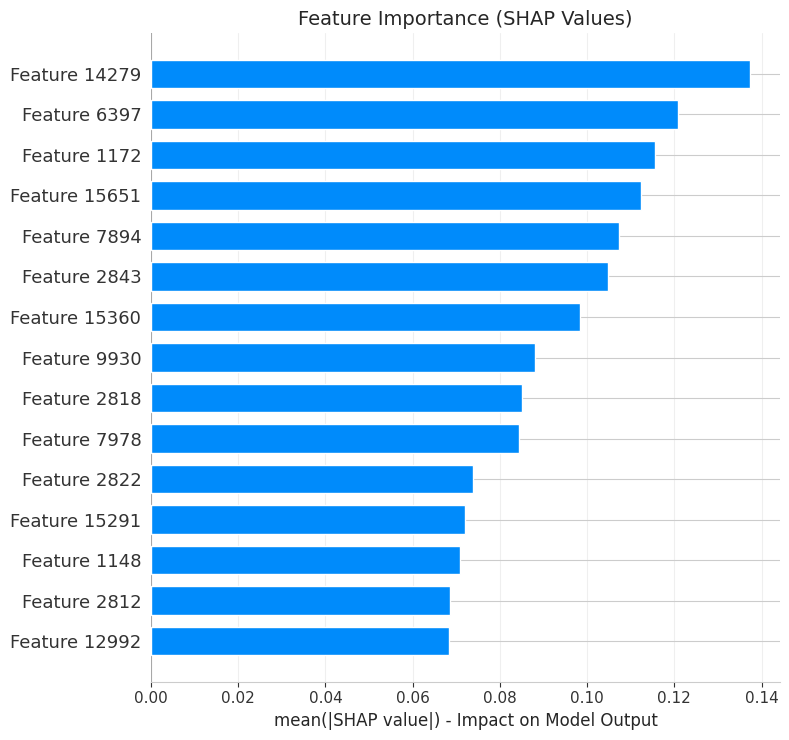

<ipython-input-34-b1d51baf0179>:63: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


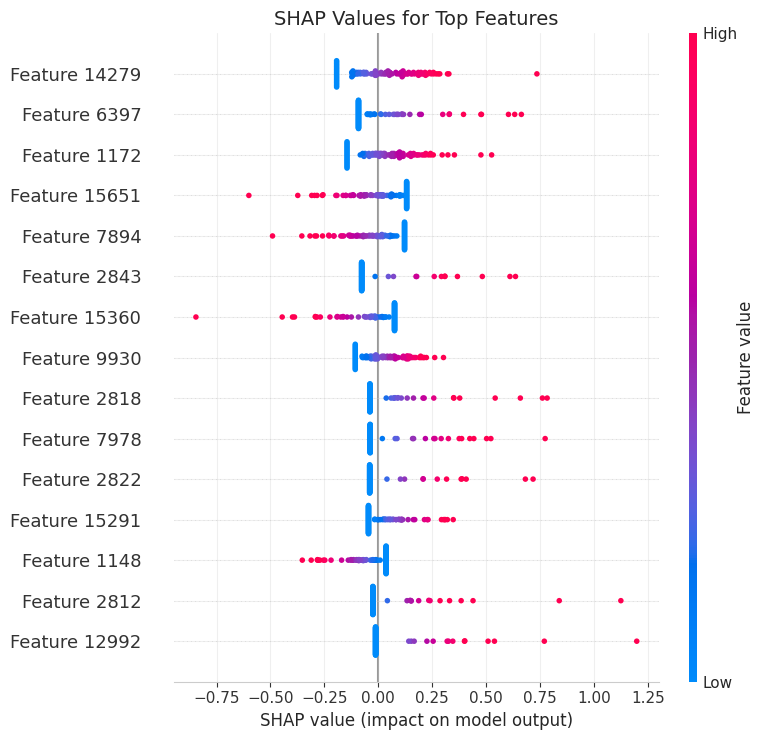

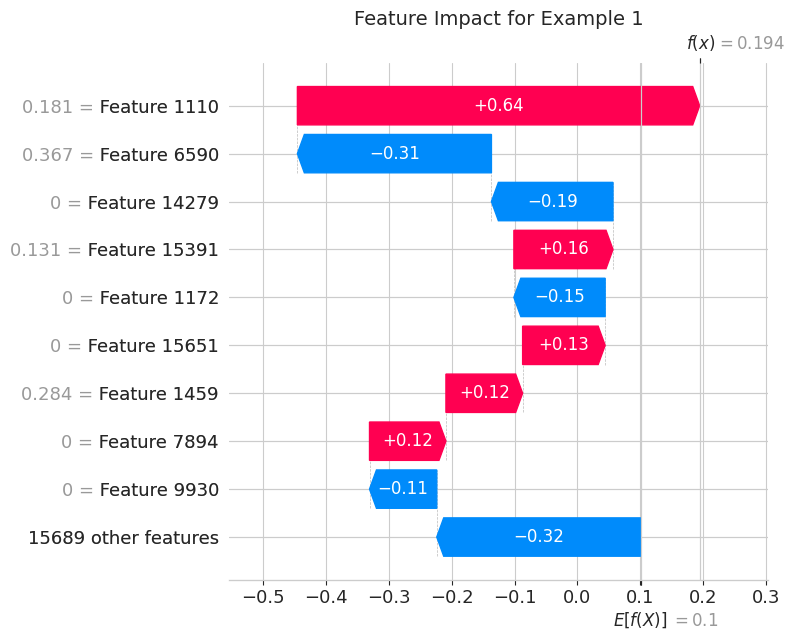

In [34]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp

# Initialize the explainer
explainer = shap.LinearExplainer(clf, X_train)

# Handle sparse matrices if needed
if sp.issparse(X_test):
    # For smaller datasets, convert to dense
    if X_test.shape[0] * X_test.shape[1] < 1e6:  # Reasonable size check
        X_test_for_shap = X_test.toarray()
    else:
        # For large sparse matrices, use a subset
        sample_size = min(100, X_test.shape[0])
        sample_indices = np.random.choice(X_test.shape[0], sample_size, replace=False)
        X_test_for_shap = X_test[sample_indices].toarray()
else:
    X_test_for_shap = X_test

# Get feature names if available
feature_names = None
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns.tolist()

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_for_shap)

# Handle multi-class models
if isinstance(shap_values, list):
    # For multi-class, use the first class
    shap_values_plot = shap_values[0]
else:
    shap_values_plot = shap_values

# Create figure with appropriate size
plt.figure(figsize=(12, 8))

# Create a clean summary plot (improved readability)
shap.summary_plot(
    shap_values_plot,
    X_test_for_shap,
    feature_names=feature_names,
    plot_type="bar",  # Use bar plot for cleaner look
    max_display=15,   # Limit to top 15 features for readability
    show=False        # Don't show yet so we can customize
)

# Improve the plot style
plt.title("Feature Importance (SHAP Values)", fontsize=14)
plt.xlabel("mean(|SHAP value|) - Impact on Model Output", fontsize=12)
plt.tight_layout()
plt.grid(axis='x', alpha=0.3)

# Save and show the plot
plt.savefig('shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# If you prefer the beeswarm plot, here's a cleaner version
plt.figure(figsize=(12, 10))

shap.summary_plot(
    shap_values_plot,
    X_test_for_shap,
    feature_names=feature_names,
    plot_type="dot",   # Dot plot = beeswarm plot
    max_display=15,    # Top 15 features
    show=False         # Don't show yet
)

# Improve the plot style
plt.title("SHAP Values for Top Features", fontsize=14)
plt.xlabel("SHAP value (impact on model output)", fontsize=12)
plt.tight_layout()
plt.grid(alpha=0.3)

# Save and show
plt.savefig('shap_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

# For individual feature exploration, we can create waterfall plots
# for a few examples (they're usually cleaner and easier to read)
plt.figure(figsize=(10, 6))

# Get a single example
example_idx = 0
if sp.issparse(X_test):
    example = X_test[example_idx].toarray().reshape(1, -1)
elif hasattr(X_test, 'iloc'):
    example = X_test.iloc[[example_idx]]
else:
    example = X_test[example_idx:example_idx+1]

# Calculate SHAP values for this example
example_shap_values = explainer.shap_values(example)
if isinstance(example_shap_values, list):
    example_values = example_shap_values[0]
else:
    example_values = example_shap_values

# Get base value
base_value = explainer.expected_value
if isinstance(base_value, list):
    base_value = base_value[0]

# Create explanation
example_data = example.toarray()[0] if sp.issparse(example) else example.values[0] if hasattr(example, 'values') else example[0]

# Create a waterfall plot for this example
shap.plots.waterfall(
    shap.Explanation(
        values=example_values[0],
        base_values=base_value,
        data=example_data,
        feature_names=feature_names
    ),
    max_display=10,  # Show only top 10 for clarity
    show=False
)

plt.title(f"Feature Impact for Example {example_idx+1}", fontsize=14)
plt.tight_layout()
plt.savefig('shap_waterfall.png', dpi=300, bbox_inches='tight')
plt.show()

### Part (C)


#### Part (i)

In [ ]:
# Compute the accuracy of the classifier and the number of misclassified documents
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
num_misclassified = len(misclassified)
print(f"Accuracy: {accuracy:.4f}")
print(f"Number of misclassified documents: {num_misclassified}")


#### Part (ii)

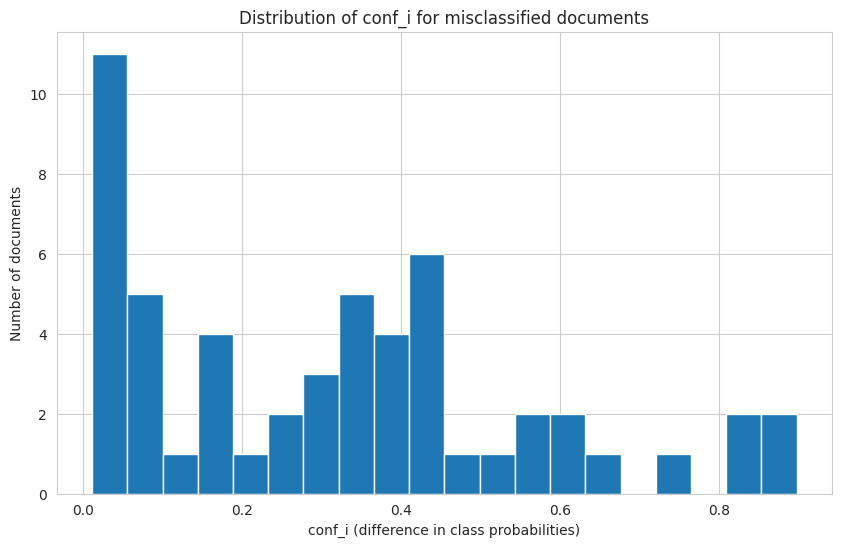

In [5]:


# Calculate conf_i for all misclassified documents
conf_i_values = []
for idx in misclassified:
    # Get probability scores
    probs = clf.predict_proba(X_test[idx].reshape(1, -1))[0]
    # Calculate conf_i as the difference between the probabilities
    conf_i = abs(probs[1] - probs[0])
    conf_i_values.append(conf_i)

# Plot conf_i
plt.figure(figsize=(10, 6))
plt.hist(conf_i_values, bins=20)
plt.xlabel('conf_i (difference in class probabilities)')
plt.ylabel('Number of documents')
plt.title('Distribution of conf_i for misclassified documents')
plt.show()


#### Part (iii)


Top words contributing to misclassifications by count_j:
organization: 27 documents, total weight: 0.2398
christian: 24 documents, total weight: 3.9347
lines: 23 documents, total weight: 0.1379
edu: 21 documents, total weight: 1.2762
subject: 21 documents, total weight: 0.2068
university: 21 documents, total weight: 1.0749
god: 21 documents, total weight: 3.0495
believe: 20 documents, total weight: 0.8258
just: 18 documents, total weight: 0.1660
jesus: 17 documents, total weight: 2.5602
years: 14 documents, total weight: 0.1632
good: 13 documents, total weight: 0.1640
world: 12 documents, total weight: 0.0231
great: 12 documents, total weight: 0.2242
know: 12 documents, total weight: 0.7206
time: 12 documents, total weight: 0.0846
christ: 12 documents, total weight: 2.6729
christians: 12 documents, total weight: 1.9937
death: 11 documents, total weight: 0.0675
did: 11 documents, total weight: 0.2390

Top words contributing to misclassifications by weight_j:
christian: weight: 3.9347, 

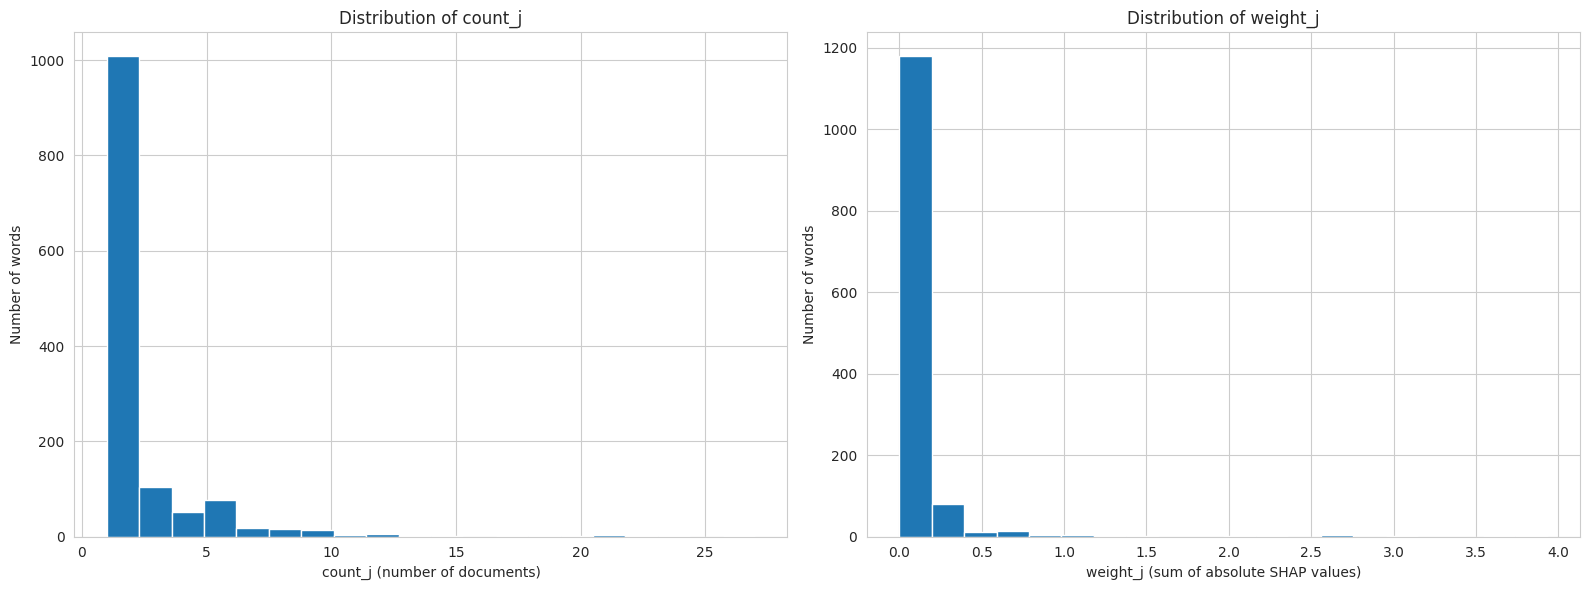

In [6]:
# Identify tokens (word_j) that contributed to the misclassification of documents
word_contrib = defaultdict(list)

for idx in misclassified:
    # Get the document words
    doc_words = X_test[idx].nonzero()[1]

    # Get SHAP values for this document
    shap_values_doc = shap_values[idx]

    # Determine which class was predicted
    pred_class = y_pred[idx]

    # For each word, check if it contributed to the wrong classification
    for word_idx in doc_words:
        # If SHAP value is positive for predicted class or negative for the other class,
        # it contributed to the misclassification
        if (pred_class == 1 and shap_values_doc[word_idx] > 0) or \
           (pred_class == 0 and shap_values_doc[word_idx] < 0):
            word_contrib[word_idx].append((idx, abs(shap_values_doc[word_idx])))

# Compute the number of documents (count_j) these words helped to misclassify
count_j = {word: len(docs) for word, docs in word_contrib.items()}

# Compute the sum of absolute SHAP values (weight_j) for each word_j
weight_j = {word: sum(weight for _, weight in docs) for word, docs in word_contrib.items()}

# Get word representations for reporting
words = vectorizer.get_feature_names_out()
word_list = []
for word_idx in word_contrib:
    word_list.append({
        'word': words[word_idx],
        'count_j': count_j[word_idx],
        'weight_j': weight_j[word_idx]
    })

# Sort by count_j and weight_j for reporting
word_list_by_count = sorted(word_list, key=lambda x: x['count_j'], reverse=True)
word_list_by_weight = sorted(word_list, key=lambda x: x['weight_j'], reverse=True)

print("\nTop words contributing to misclassifications by count_j:")
for item in word_list_by_count[:20]:
    print(f"{item['word']}: {item['count_j']} documents, total weight: {item['weight_j']:.4f}")

print("\nTop words contributing to misclassifications by weight_j:")
for item in word_list_by_weight[:20]:
    print(f"{item['word']}: weight: {item['weight_j']:.4f}, {item['count_j']} documents")

# Plot the distribution of count_j and weight_j
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.hist([item['count_j'] for item in word_list], bins=20)
plt.xlabel('count_j (number of documents)')
plt.ylabel('Number of words')
plt.title('Distribution of count_j')

plt.subplot(1, 2, 2)
plt.hist([item['weight_j'] for item in word_list], bins=20)
plt.xlabel('weight_j (sum of absolute SHAP values)')
plt.ylabel('Number of words')
plt.title('Distribution of weight_j')

plt.tight_layout()
plt.show()

### Part (D)

In [18]:
import numpy as np
import shap
import scipy.sparse
from sklearn.linear_model import SGDClassifier
import sklearn.metrics

accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
num_misclassified = len(np.where(y_test != y_pred)[0])

# Implement a strategy for feature selection
sorted_words_by_weight = sorted(
    word_contrib.items(),
    key=lambda x: sum(weight for _, weight in x[1]),
    reverse=True
)

top_n = 50
words_to_remove = [word_idx for word_idx, _ in sorted_words_by_weight[:top_n]]

feature_names = vectorizer.get_feature_names_out()
print("Words being removed for feature selection:")
for word_idx in words_to_remove[:20]:
    print(f"- {feature_names[word_idx]}")

X_train_new = X_train.copy()
X_train_new = X_train_new.toarray()
X_train_new[:, words_to_remove] = 0
X_train_new = scipy.sparse.csr_matrix(X_train_new)

X_test_new = X_test.copy()
X_test_new = X_test_new.toarray()
X_test_new[:, words_to_remove] = 0
X_test_new = scipy.sparse.csr_matrix(X_test_new)

clf_new = SGDClassifier(loss='log_loss', random_state=42)
clf_new.fit(X_train_new, y_train)

y_pred_new = clf_new.predict(X_test_new)
accuracy_new = sklearn.metrics.accuracy_score(y_test, y_pred_new)
conf_matrix_new = sklearn.metrics.confusion_matrix(y_test, y_pred_new)

print(f"\nOriginal accuracy: {accuracy:.4f}")
print(f"New accuracy after feature selection: {accuracy_new:.4f}")
print("\nNew confusion matrix:")
print(conf_matrix_new)

# Identify at least one example that was misclassified before feature selection and that is classified correctly after feature selection
fixed_examples = np.where((y_test != y_pred) & (y_test == y_pred_new))[0]

if len(fixed_examples) > 0:
    print(f"\nFound {len(fixed_examples)} examples that were misclassified before but are now correctly classified.\n")
    example_idx = fixed_examples[0]
    print("Example document that was fixed after feature selection:")
    print(f"True class: {class_names[y_test[example_idx]]}")
    print(f"Original prediction: {class_names[y_pred[example_idx]]}")
    print(f"New prediction: {class_names[y_pred_new[example_idx]]}")
    explainer_new = shap.LinearExplainer(clf_new, X_train_new)
    shap_values_old_all = explainer.shap_values(X_test[[example_idx]])
    shap_values_old = shap_values_old_all[0]
    shap_values_new_all = explainer_new.shap_values(X_test_new[[example_idx]])
    shap_values_new = shap_values_new_all[0]
    print("\nDocument content:")
    print(newsgroups_test.data[example_idx][:500] + "...")
    doc_words = X_test[example_idx].nonzero()[1]
    shap_changes = []
    for word_idx in doc_words:
        if word_idx in words_to_remove:
            change = {
                'word': feature_names[word_idx],
                'old_shap': shap_values_old[word_idx],
                'new_shap': 0,
                'change': -abs(shap_values_old[word_idx])
            }
        else:
            change = {
                'word': feature_names[word_idx],
                'old_shap': shap_values_old[word_idx],
                'new_shap': shap_values_new[word_idx],
                'change': shap_values_new[word_idx] - shap_values_old[word_idx]
            }
        shap_changes.append(change)
    shap_changes.sort(key=lambda x: abs(x['change']), reverse=True)
    print("\nWords with largest change in influence:")
    for change in shap_changes[:10]:
        print(
            f"{change['word']}: old SHAP = {change['old_shap']:.4f}, "
            f"new SHAP = {change['new_shap']:.4f}, change = {change['change']:.4f}"
        )
else:
    print("No examples were fixed after feature selection.")


Words being removed for feature selection:
- christian
- love
- god
- christ
- church
- atheism
- jesus
- faith
- christians
- princeton
- edu
- atheist
- university
- mangoe
- atheists
- james
- black
- temple
- truth
- believe

Original accuracy: 0.9247
New accuracy after feature selection: 0.9442

New confusion matrix:
[[282  37]
 [  3 395]]

Found 24 examples that were misclassified before but are now correctly classified.

Example document that was fixed after feature selection:
True class: christian
Original prediction: atheism
New prediction: christian

Document content:
From: tdarcos@access.digex.net (Paul Robinson)
Subject: Homosexuality is Immoral (non-religious argument)
Organization: Tansin A. Darcos & Company, Silver Spring, MD USA
Lines: 43

[This was crossposted to a zillion groups.  I don't intend to
carry an entire discussion crossposted from alt.sex, particularly
one whose motivation seems to be having a fun argument.  However
I thought readers might be interested to 

In [15]:
print("shap_values_old_all shape:", np.array(shap_values_old_all).shape)
print("shap_values_new_all shape:", np.array(shap_values_new_all).shape)
print("example_idx:", example_idx)
print("doc_words:", doc_words)


shap_values_old_all shape: (1, 5000)
shap_values_new_all shape: (1, 5000)
example_idx: 1
doc_words: [  49   76  137  152  157  196  272  302  347  368  419  430  451  466
  469  503  507  515  533  548  589  752  818  876  896  957 1236 1240
 1391 1429 1440 1581 1711 1790 1865 1885 1911 2035 2095 2174 2223 2225
 2250 2345 2346 2355 2356 2363 2467 2502 2551 2642 2659 2672 2679 2698
 2727 2762 2763 2770 2983 2984 2998 3078 3112 3118 3239 3304 3325 3338
 3427 3456 3457 3467 3691 3704 3717 3728 3795 3797 3852 4082 4085 4091
 4140 4267 4282 4284 4289 4295 4356 4407 4439 4525 4528 4534 4556 4634
 4722 4723 4727 4732 4751 4841 4844 4917 4940]
